### Goals

0. We need to map velocities to the atmosphere somehow. what parameterizations are "simple"?

  * fixed/solid body rotation
  * differential rotation

1. $K_p-v_{\rm sys}$ diagram for a planet (for now we'll use a stellar spectrum) that is orbiting a star, with a velocity field in its atmosphere

2. estimate the effect of a velocity field throughout the terminator on the transmission spectrum

3. compare GCM velocity fields with observations (in transit transmission and in full-orbit CCFs)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from expecto import get_spectrum  # downloads phoenix model spectra
from tqdm.auto import tqdm
from ipywidgets import interactive
from specutils import Spectrum1D

Set up the lon ($\phi$), lat ($\theta$), and orbital phase ($\xi$) grids:

In [2]:
n_obs_per_orbit = 50

n_lats = 7
n_lons = 25
phi = np.linspace(0, 2*np.pi, n_lons)

lat_frac = 0.9
theta = np.arcsin(np.linspace(-lat_frac, lat_frac, n_lats))

xi = np.linspace(-np.pi, np.pi, n_obs_per_orbit)

Rp = 1 * u.R_jup

phi2d, theta2d = np.meshgrid(
    phi, theta
)

phi3d, theta3d, xi3d = np.meshgrid(
    phi, theta, xi
)

$$ v(\phi, \theta) = \sin(\theta) $$

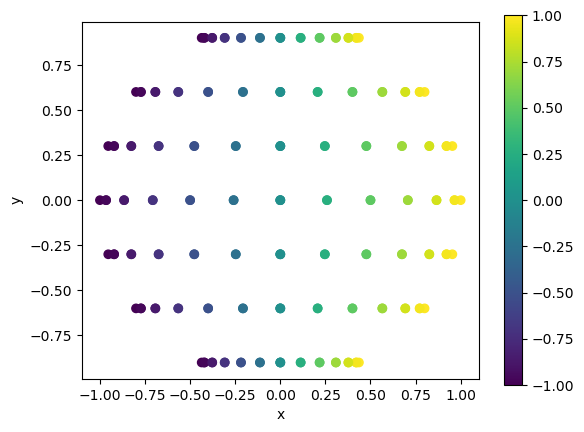

In [3]:
x = Rp * np.cos(theta3d) * np.sin(phi3d)
y = Rp * np.sin(theta3d)
z = Rp * np.sin(theta3d) * np.sin(phi3d)

dx = - np.sin(phi3d)
dy = np.cos(phi3d)
dz = np.zeros_like(phi3d)

plt.scatter(x[..., 0].value.ravel(), y[..., 0].value.ravel(), c=-dx[..., 0].ravel())
plt.colorbar()
plt.gca().set(
    xlabel='x', 
    ylabel='y'
)
plt.gca().set_aspect('equal')

In [4]:
# download the phoenix model spectrum:
spec_full = get_spectrum(2300, 5.0, cache=True)

def spectral_binning(y, all_x, all_y):
    """
    Spectral binning via trapezoidal approximation.
    """
    min_ind = np.argwhere(all_y == y[0])[0, 0]
    max_ind = np.argwhere(all_y == y[-1])[0, 0]
    if max_ind > min_ind and y.shape == all_x[min_ind:max_ind + 1].shape:
        return np.trapz(y, all_x[min_ind:max_ind + 1]) / (all_x[max_ind] - all_x[min_ind])
    return np.nan

def bin_spectrum(spectrum, bins=None, log=True, min=None, max=None, **kwargs):
    """
    Bin a spectrum, with log-spaced frequency bins.

    Parameters
    ----------
    spectrum : 
    log : bool
        If true, compute bin edges based on the log base 10 of
        the frequency.
    bins : int or ~numpy.ndarray
        Number of bins, or the bin edges

    Returns
    -------
    new_spectrum : 
    """
    from scipy.stats import binned_statistic
    
    nirspec_wl_range = (spectrum.wavelength > min) & (spectrum.wavelength < max)
    
    wavelength = spectrum.wavelength[nirspec_wl_range]
    flux = spectrum.flux[nirspec_wl_range]

    if log:
        wl_axis = np.log10(wavelength.to(u.um).value)
    else:
        wl_axis = wavelength.to(u.um).value

    # Bin the power spectrum:
    bs = binned_statistic(
        wl_axis, flux.value,
        statistic=lambda y: spectral_binning(
            y, all_x=wl_axis, all_y=flux.value
        ),
        bins=bins
    )
    if log:
        wl_bins = 10 ** (
            0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])
        ) * u.um
    else:
        wl_bins = (
            0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])
        ) * u.um
    nans = np.isnan(bs.statistic)
    interp_fluxes = bs.statistic.copy()
    interp_fluxes[nans] = np.interp(wl_bins[nans], wl_bins[~nans], bs.statistic[~nans])
    return Spectrum1D(flux=interp_fluxes * flux.unit, spectral_axis=wl_bins)

minimum_wavelength, maximum_wavelength = 0.4*u.um, 0.8*u.um

# bin the phoenix model spectrum
spec = bin_spectrum(
    spec_full, bins=10_000, 
    min=minimum_wavelength, max=maximum_wavelength, 
    log=False
)

flux_unit = spec.flux.unit
wavelength = spec.wavelength

# this assumes that the whole planet is emitting with the same spectrum, 
# and the observed differences are only due to the observer's frame of reference
flux_cube = np.squeeze(spec.flux.to(flux_unit).value[:, None, None, None] * np.ones_like(x)[None, None, None, :])

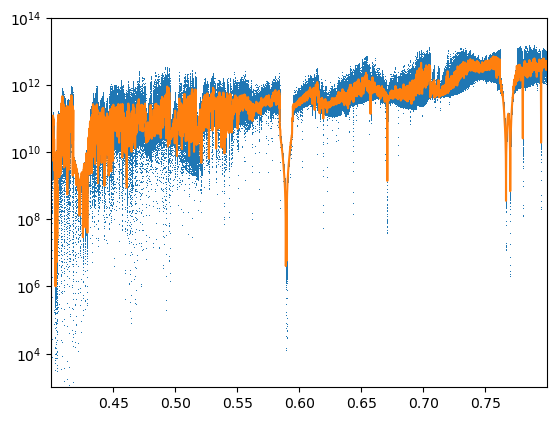

In [5]:
plt.semilogy(spec_full.wavelength.to(u.um).value, spec_full.flux.to(flux_unit).value, ',')
plt.semilogy(spec.wavelength.to(u.um).value, spec.flux.to(flux_unit).value)
plt.xlim(spec.wavelength.min().to(u.um).value, spec.wavelength.max().to(u.um).value)
plt.ylim(1e3, 1e14)
plt.show()

The shape of the resulting `flux_cube` is (wavelength, lat, lon, time/phase): $N_\lambda, N_\theta, N_\phi$, $N_\xi$

Now let's start with a fixed velocity map:

In [6]:
orbital_period = 3 * u.day
eq_rotation_velocity = (2 * np.pi * Rp / orbital_period).to(u.km/u.s)
# eastward rotational velocity depends on latitude:
rotation_velocity = eq_rotation_velocity * np.cos(theta3d)

In [7]:
eq_velocity = 100 * u.km/u.s
pole_velocity = 5 * u.km/u.s
alpha = float((eq_velocity - pole_velocity) / pole_velocity)

# this is the variation of wind velocity with latitude, written in
# the form often used to describe stellar differential rotation:
differential_rotation = pole_velocity * (1 + alpha * np.cos(theta3d))

# the velocity map will be asymmetric using this longitudinal scale factor:
delta_phi = 0.4  # phase offset of the wind asymmetry
asymmetry = 0.4  # asymmetry strength in units of fraction of differential rotation amplitude:

velocity_map = (
    differential_rotation * (1 + asymmetry * (np.sin(phi3d - delta_phi) - 1)) + 
    eq_rotation_velocity
)

radial_velocity_map = velocity_map * dx

Compute the "visibility" of each spatial pixel on the sphere. `1` is a pixel viewed face-on, `0` is a pixel that is not visible.

In [8]:
# this visibility goes from (-1, 1)
visibility_no_clipping = np.cos(phi3d - np.pi - xi) * np.sin(theta3d + np.pi/2)**2

# this visibility has minimum = 0
visibility = np.cos(phi3d - np.pi - xi) * np.sin(theta3d + np.pi/2)**2
visibility[visibility < 0] = 0

Plot them all:

/var/folders/26/01khn44s6z13flg3_1qqk7b00000gn/T/ipykernel_10899/1064468779.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = axis.pcolormesh(phi - np.pi, theta, visibility[..., int(i*len(xi) / viz_n_phases)])


Text(0.5, 0.98, 'Visibility over time, as the world turns')

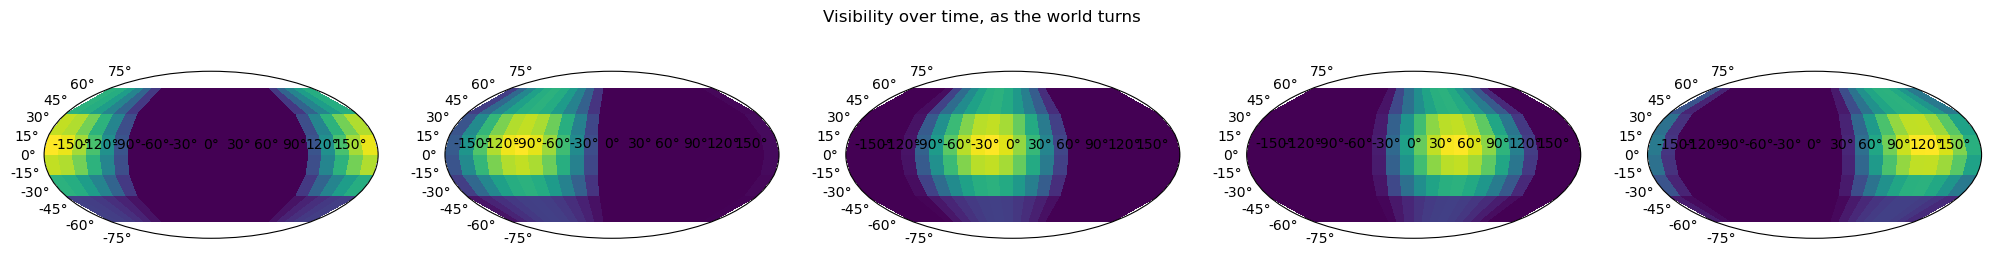

In [9]:
fig = plt.figure(figsize=(25, 3))

viz_n_phases = 5
for i in range(viz_n_phases):
    axis = fig.add_subplot(100 + 10 * viz_n_phases + 1 + i, projection='mollweide')
    cax = axis.pcolormesh(phi - np.pi, theta, visibility[..., int(i*len(xi) / viz_n_phases)])
    #plt.colorbar(cax, ax=axis, label='visibility')
fig.suptitle('Visibility over time, as the world turns')

/var/folders/26/01khn44s6z13flg3_1qqk7b00000gn/T/ipykernel_10899/1830926422.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax0.pcolormesh(phi - np.pi, theta, velocity_map[..., xi_ind], vmin=0)
/var/folders/26/01khn44s6z13flg3_1qqk7b00000gn/T/ipykernel_10899/1830926422.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax1.pcolormesh(phi - np.pi, theta, visibility[..., xi_ind], cmap=plt.cm.Greys_r)
/var/folders/26/01khn44s6z13flg3_1qqk7b0000

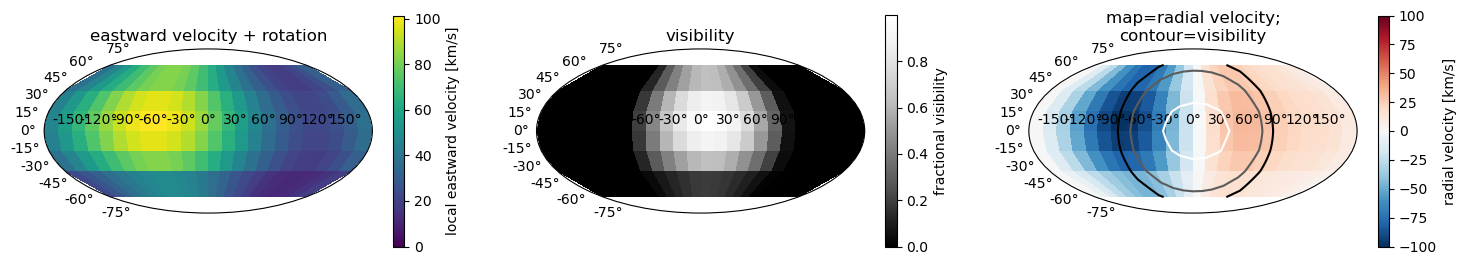

In [10]:
xi_ind = len(xi)//2
fig = plt.figure(figsize=(18, 3))
ax0 = fig.add_subplot(131, projection='mollweide')
ax1 = fig.add_subplot(132, projection='mollweide')
ax2 = fig.add_subplot(133, projection='mollweide')
cax = ax0.pcolormesh(phi - np.pi, theta, velocity_map[..., xi_ind], vmin=0)
plt.colorbar(cax, ax=ax0, label='local eastward velocity [km/s]')
cax = ax1.pcolormesh(phi - np.pi, theta, visibility[..., xi_ind], cmap=plt.cm.Greys_r)
plt.colorbar(cax, ax=ax1, label='fractional visibility')
vmin, vmax = np.array([-1, 1]) * 100
cax = ax2.pcolormesh(phi - np.pi, theta, radial_velocity_map[..., xi_ind], cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax)
plt.colorbar(cax, ax=ax2, label='radial velocity [km/s]')

cax = ax2.contour(phi - np.pi, theta, visibility[..., xi_ind], levels=[0.1, 0.3, 0.8], cmap=plt.cm.Greys_r)

ax0.set_title('eastward velocity + rotation')
ax1.set_title('visibility')
ax2.set_title('map=radial velocity;\ncontour=visibility')
plt.show()

Now for each spatial pixel on the sphere in $\theta, \phi$, compute the redshifts/blueshifts for each wavelength at each pixel:

In [11]:
wavelength_cube = radial_velocity_map[None, ...].to(u.nm, u.doppler_optical(wavelength[:, None, None, None]))

Take the flux cube (wave, lat, lon) and scale it by the visibility of each spatial pixel on the sphere:

In [12]:
weighted_flux_cube = flux_cube * visibility[None, ...] # weighting the spectrum by the visibility

The weighted flux cube has doppler shifted wavelengths, but the observer only sees a single set of wavelengths (named here `wavelength`). Let's interpolate the doppler shifted spectra onto each observer-frame wavelength, at each spatial pixel:

In [13]:
shifted_weighted_flux_cube = np.empty(weighted_flux_cube.shape)
new_shape = (weighted_flux_cube.shape[0], np.prod(weighted_flux_cube.shape[1:-1]))

for j in tqdm(range(len(xi))):
    # We're going to take the 3D cube, and make it 2D temporarily so we can interpolate efficiently:
    wavelength_cube_j = wavelength_cube[..., j].reshape(new_shape)
    shifted_weighted_flux_cube_j = np.empty(new_shape)
    weighted_flux_cube_j = weighted_flux_cube[..., j].reshape(new_shape)
    # loop over the (now single) spatial dimension and interpolate in the wavelength dimension
    for i in range(shifted_weighted_flux_cube_j.shape[1]):
        shifted_weighted_flux_cube_j[:, i] = np.interp(
            wavelength.to(u.um).value, 
            wavelength_cube_j[:, i].to(u.um).value, 
            weighted_flux_cube_j[:, i].value
        )
    shifted_weighted_flux_cube[..., j] = shifted_weighted_flux_cube_j.reshape(weighted_flux_cube.shape[:-1])

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# the observed spectrum of the visible hemisphere, as a function of time, is: 
observed_spectrum = shifted_weighted_flux_cube.sum(axis=(1, 2))  # in un-normalized units

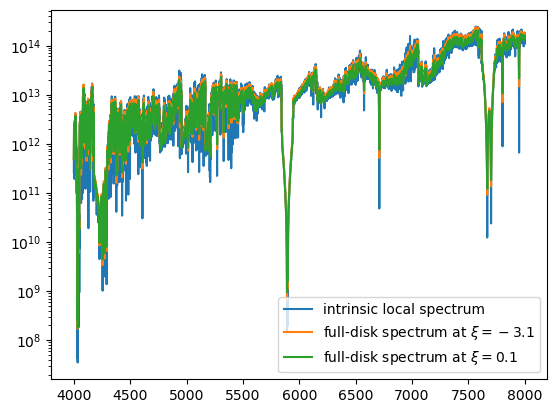

In [15]:
# this normalization factor shifts a single spatial element's spectrum up to the same scale
# as the observed spectrum of a full hemisphere:
norm = spec.flux.max() / observed_spectrum.max()
plt.semilogy(wavelength, spec.flux / norm, label='intrinsic local spectrum')
plt.plot(
    wavelength, observed_spectrum[:, 0], 
    label=f'full-disk spectrum at $\\xi = {xi[0]:.1f}$'
)
plt.plot(
    wavelength, observed_spectrum[:, observed_spectrum.shape[1]//2], 
    label=f'full-disk spectrum at $\\xi = {xi[observed_spectrum.shape[1]//2]:.1f}$'
)
plt.legend()

Find the latitudinally averaged radial velocity on the terminator to identify the velocity shifts of the transmission spectrum on the limb at ingress and egress

In [16]:
# latitudinal-mean of the visibility:
lat_avgd_vis = visibility_no_clipping.mean(axis=0)
# take numerical derivative, zero crossings occur at extrema:
diff_vis = np.diff(lat_avgd_vis, axis=1)
# find longitude indices where the visibility changes sign:
lon_indicies_maxs = np.argmax(diff_vis, axis=0)
lon_indicies_mins = np.argmin(diff_vis, axis=0)

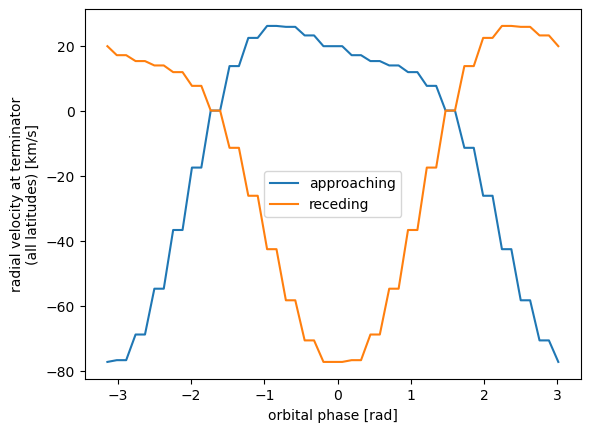

In [17]:
# the "approaching" terminator is where the visibility goes 
# from negative to positive. this is the limb that is
# rotating towards the observer
mean_radvel_on_terminator_approaching = np.take_along_axis(
    radial_velocity_map.mean(axis=0)[:, :-1], 
    lon_indicies_maxs[None, :], 
    axis=0
)[0]

# the "receding" terminator is where the visibility goes 
# from positive to negative. this is the limb that is
# rotating away from the observer
mean_radvel_on_terminator_receding = np.take_along_axis(
    radial_velocity_map.mean(axis=0)[:, :-1], 
    lon_indicies_mins[None, :], 
    axis=0
)[0]

plt.plot(xi[:-1], mean_radvel_on_terminator_approaching, label='approaching')
plt.plot(xi[:-1], mean_radvel_on_terminator_receding, label='receding')
plt.gca().set(
    xlabel='orbital phase [rad]',
    ylabel='radial velocity at terminator\n(all latitudes) [km/s]',
) 
plt.legend();

In [18]:
def spec_interact(phase, wl_zoom):
    ind = int(phase/360 * len(xi))
    fig = plt.figure(figsize=(11, 7))
    ax1 = fig.add_subplot(331, projection='mollweide')
    ax6 = fig.add_subplot(334, projection='mollweide')
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(335)
    ax4 = fig.add_subplot(333)
    ax5 = fig.add_subplot(336)
    ax0 = fig.add_subplot(337, projection='mollweide')
    ax7 = fig.add_subplot(338)

    cax = ax1.pcolormesh(phi - np.pi, theta, radial_velocity_map[..., ind])
    plt.colorbar(cax, ax=ax1, label='velocity [km/s]')
    
    cax = ax6.pcolormesh(phi - np.pi, theta, visibility[..., ind], cmap=plt.cm.Greys_r)
    plt.colorbar(cax, ax=ax6, label='fractional visibility')
    cax = ax0.pcolormesh(phi - np.pi, theta, radial_velocity_map[..., ind], cmap=plt.cm.RdBu_r)
    plt.colorbar(cax, ax=ax0, label='velocity [km/s]')

    # cax = ax1.contour(phi - np.pi, theta, visibility[..., ind], levels=[0.1, 0.3, 0.8], cmap=plt.cm.Greys_r)
    ax1.set_title('wind + rotation')
    ax6.set_title('visibility')
    ax0.set_title('radial velocity')

    norm = spec.flux.max() / observed_spectrum.max()
    for axis, pl in zip([ax2, ax3], ['semilogy', 'plot']):
        getattr(axis, pl)(wavelength, spec.flux / norm, label='intrinsic local spectrum')
        getattr(axis, pl)(wavelength, observed_spectrum[:, ind], 
            label=f'full-disk spectrum at $\\xi = {xi[ind]:.1f}$'
        )
    ax2.legend(loc=[0, 1])
    
    for axis in [ax4, ax5]:
        axis.plot(wavelength, 
            observed_spectrum[:, ind] / observed_spectrum.mean(axis=1) - 1, 
            label='intrinsic local spectrum'
        )

    
    for axis in [ax2, ax3]:
        axis.set(
            xlabel='Wavelength [Angstrom]',
            ylabel=f'Flux [{flux_unit.to_string(format="latex")}]'
        )
    for axis in [ax4, ax5]:
        axis.set(
            xlabel='Wavelength [Angstrom]',
            ylabel=f'flux relative to mean'
        )


    delta_x = 150
    zoom_x_inds = [wl_zoom, wl_zoom+delta_x]
    zoom_x = spec.wavelength[zoom_x_inds].value
    ys = observed_spectrum[zoom_x_inds[0]:zoom_x_inds[1], ind]
    zoom_y = [0.8 * ys.min(), 1.2 * ys.max()]
    for axis in [ax2, ax4]:
        axis.axvspan(*zoom_x, alpha=0.2, color='gray')
    ax3.set_xlim(zoom_x)
    ax3.set_ylim(zoom_y)
    ax5.set_xlim(zoom_x)
    ax5.set_ylim(-1, 1)
    
    terminators = [
        mean_radvel_on_terminator_approaching, 
        mean_radvel_on_terminator_receding
    ]
    labels = ['approach', 'receding']
    for terminator, label in zip(terminators, labels):
        ax7.plot(xi[:-1], terminator, label=label)
    ax7.axvline(xi[ind], color='k', ls='--')
    ax7.set(
        xlabel='phase $\\xi$ [rad]',
        ylabel='mean radvel at\nterminator [km/s]'
    )
    ax7.legend()
    fig.tight_layout()
    
print(
    'Vary orbital phase of the planet (degrees) to see the \nvisible hemisphere change'
    ', and see the evolution\nof the observed spectrum on the right:\n\n'
)
step = int(360/len(xi))
interactive_plot = interactive(
    spec_interact, 
    phase=(0, 360 - step, step),
    wl_zoom=(0, len(spec.wavelength), 100)
)
output = interactive_plot.children[-1]
interactive_plot

Vary orbital phase of the planet (degrees) to see the 
visible hemisphere change, and see the evolution
of the observed spectrum on the right:




interactive(children=(IntSlider(value=175, description='phase', max=353, step=7), IntSlider(value=5000, descri…